<a href="https://colab.research.google.com/github/atalebizadeh/My-Projects/blob/master/working_with_text_data_in_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="center">
<img src="https://github.com/datacamp/python-live-training-template/blob/master/assets/datacamp.svg?raw=True" alt = "DataCamp icon" width="50%">
</p>
<br><br>

# **Working with Text Data in Python**

Welcome to this hands-on training where you will beging to learn how to work with text data in Python! In this session you will learn:

- How to explore and visualize your text data.
- How to manipulate and clean text data for further analysis.
- The basics of regex, and how to use it to filter a DataFrame.
- How to use prepare a template that is easily reusable.

## **The Dataset**

The dataset to be used in this webinar is a CSV file named `wine_reviews.csv`, which contains data on wine reviews. In particular, it contains the following columns:

### Columns:

`country`: The country that the wine is from

`description`: The review.

`designation`: The vineyard within the winery.

`points`: The number of points awarded to the wine on a scale from 1-100.

`price`: The cost of the wine.

`province`: The province or state where the wine originated from.

`region`: The wine growing area within the province or state.

`variety`: The type of grapes used to make the wine.

In [1]:
# Load resources
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
from collections import Counter

# Set pandas columns to display at max width
pd.set_option('display.max_colwidth', None)

# Set seaborn aesthetic features to pretty up our plots
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Import wine data, and look at the first five rows**
Let's first import the data which is stored in the csv `wine_reviews.csv` and inspect it. We will use:
- `read_csv()` to read the csv file as a DataFrame.
- `.head()` to view the first five rows.

In [2]:
# Read the csv and assign to the DataFrame 'wine_df'
wine_df = pd.read_csv('https://github.com/datacamp/working-with-text-data-in-python-live-training/blob/master/data/wine_reviews.csv?raw=true')

# View the first five rows
wine_df.head()

,country,description,designation,points,price,province,region,variety,winery
0,US,"This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.",Martha's Vineyard,96,235.0,California,Napa Valley,Cabernet sauvignon,Heitz
1,US,"Mac Watson honors the memory of a wine once made by his mother in this tremendously delicious, balanced and complex botrytised white. Dark gold in color, it layers toasted hazelnut, pear compote and orange peel flavors, reveling in the succulence of its 122 g/L of residual sugar.",Special Selected Late Harvest,96,90.0,California,Knights Valley,sauvignon blanc,Macauley
2,US,"This spent 20 months in 30% new French oak, and incorporates fruit from Ponzi's Aurora, Abetina and Madrona vineyards, among others. Aromatic, dense and toasty, it deftly blends aromas and flavors of toast, cigar box, blackberry, black cherry, coffee and graphite. Tannins are polished to a fine sheen, and frame a finish loaded with dark chocolate and espresso. Drink now through 2032.",Reserve,96,65.0,Oregon,Willamette Valley,PINOT NOIR,Ponzi
3,US,"This re-named vineyard was formerly bottled as deLancellotti. You'll find striking minerality underscoring chunky black fruits. Accents of citrus and graphite comingle, with exceptional midpalate concentration. This is a wine to cellar, though it is already quite enjoyable. Drink now through 2030.",Silice,95,65.0,Oregon,Chehalem Mountains,Pinot noir,Bergström
4,US,"The producer sources from two blocks of the vineyard for this wine—one at a high elevation, which contributes bright acidity. Crunchy cranberry, pomegranate and orange peel flavors surround silky, succulent layers of texture that present as fleshy fruit. That delicately lush flavor has considerable length.",Gap's Crown Vineyard,95,60.0,California,Sonoma Coast,Pinot noir,Blue Farm


**Observation:** It looks as though there are a variety of different cases in the `variety` column, which we will need to address later.

**Further inspection of our data**
---
First, now that we have an idea how our data is structured, and a little bit about what it contains, let's dig into the details a bit more. To do so, we will use: 
- `.info()` method on the DataFrame to learn about the data types and missing values.
- `.sort_values()` to reorder the DataFrame by a given series.
- `.unique()` to access the unique values.

In [3]:
# Display key information about the DataFrame
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4131 entries, 0 to 4130
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      4131 non-null   object 
 1   description  4131 non-null   object 
 2   designation  2792 non-null   object 
 3   points       4131 non-null   int64  
 4   price        4131 non-null   float64
 5   province     4131 non-null   object 
 6   region       4131 non-null   object 
 7   variety      4131 non-null   object 
 8   winery       4131 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 290.6+ KB


**Observation:** The two numeric columns, points and price, are correctly specified as integers and floats. However, it appears as though there are a lot of missing values for the designation column, which specifies what winery the wine originated from.

In [4]:
# Access the variety column, sort them alphabetically, and select only the unique values
wine_df['variety'].sort_values().unique()

array([' BORDEAUX-STYLE RED BLEND', ' Bordeaux-style red blend',
       ' CABERNET SAUVIGNON', ' CHARDONNAY', ' Cabernet sauvignon',
       ' Chardonnay', ' MERLOT', ' Merlot', ' PINOT NOIR', ' Pinot noir',
       ' RED BLEND', ' RIESLING', ' Red blend', ' Riesling',
       ' SAUVIGNON BLANC', ' SYRAH', ' Sauvignon blanc', ' Syrah',
       ' bordeaux-style red blend', ' cabernet sauvignon', ' chardonnay',
       ' merlot', ' pinot noir', ' red blend', ' riesling',
       ' sauvignon blanc', ' syrah', 'BORDEAUX-STYLE  RED  BLEND',
       'BORDEAUX-STYLE RED BLEND', 'BORDEAUX-STYLE RED BLEND ',
       'Bordeaux-style  red  blend', 'Bordeaux-style red blend',
       'Bordeaux-style red blend ', 'CABERNET  SAUVIGNON',
       'CABERNET SAUVIGNON', 'CABERNET SAUVIGNON ', 'CHARDONNAY',
       'CHARDONNAY ', 'Cabernet  sauvignon', 'Cabernet sauvignon',
       'Cabernet sauvignon ', 'Chardonnay', 'Chardonnay ', 'MERLOT',
       'MERLOT ', 'Merlot', 'Merlot ', 'PINOT  NOIR', 'PINOT NOIR',
      

**Observation:** Due to extra spaces and inconsistencies in case, there are many duplicate entries of wine varieties that we will need to address.

## **Cleaning the data**
As observed when exploring data, the `designation` column has missing values. One strategy to follow could be filling missing values with the name of the winery attached with `'- unknown'`. To fill out missing values, we can use the `.fillna()` method which takes in the following argument:
- Here we will pass the `winery` series of our DataFrame, and then concatenate `- unknown`.
- We will also use the `inplace` argument to apply this operation directly to our DataFrame.

But first, let's go over string **concatenation**. In the example below, we join the word `"the"` with our `x` variable containing `"winery"`, and separate the two words by also adding a space (`" "`).

In [5]:
# Create two variables storing the words of interest
x = 'winery'

y = 'the'

# Combine the words with a space
y + " " + x

'the winery'

In [6]:
# Fill our designation column with the name of the winery and 'unknown'
wine_df['designation'].fillna(wine_df['winery'] + " - unknown", inplace=True)

# Sample the DataFrame to see the result
wine_df.sample(5)

,country,description,designation,points,price,province,region,variety,winery
1210,US,"There's a smoky oak tinge to this bottling from actress Challen Cates and winemaker Kevin Law, with black raspberry and sandalwood notes as well. The palate intrigues with salty dark cranberry and penetrating Mediterranean herb flavors.",Lindsay's Vineyard,91,55.0,California,Sta. Rita Hills,Pinot noir,Challen
2956,France,"A blend dominated by Malbec, this wine comes from one of the estates managed by the Marmande cooperative. It has fine tannins and attractively juicy black fruits. The wine is balanced with plenty of fruity acidity. Drink from 2019.",Château la Vieille Eglise,90,15.0,Southwest France,Côtes du Marmandais,BORDEAUX-STYLE RED BLEND,Cave du Marmandais
2269,Italy,"A blend of Sangiovese, Merlot and Cabernet Sauvignon, this opens with aromas of charred earth, game and a funky whiff of barnyard. The evolved palate offers dried black cherries, prune, coffee, clove, oak and licorice alongside fleeting but astringent tannins.",Il Blu,87,85.0,Tuscany,Toscana,Red blend,Brancaia
2770,US,"Spicy in a complexity of ginger and vanilla-kissed oak, this wine is made from 15-year-old Wente selection vines. Layered in lemon, lime and green apple, it features a slab of tropical pineapple on the finish. Buttery dishes will pair well.",Wildwood Vineyard,87,30.0,California,Sonoma Valley,Chardonnay,Kunde
2698,US,"A barrel selection from estate-grown grapes, this Pinot succeeds in rich red raspberry and an offering of strawberry-rhubarb pie, the texture velvety smooth. The oak builds through the finish, providing ample body and substance, yet the wine stays light and lilting on the palate, inviting one in for more.",Lone Tree Vineyard,94,60.0,California,Carneros,PINOT NOIR,Acacia


In [7]:
# Use .info() again to ensure that we have no more missing values
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4131 entries, 0 to 4130
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      4131 non-null   object 
 1   description  4131 non-null   object 
 2   designation  4131 non-null   object 
 3   points       4131 non-null   int64  
 4   price        4131 non-null   float64
 5   province     4131 non-null   object 
 6   region       4131 non-null   object 
 7   variety      4131 non-null   object 
 8   winery       4131 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 290.6+ KB


**Observation:** Currently, there are a number of location attributes scattered across columns. While it is useful to have them separately, let's also make a column that combines this data into a useful `location` column. 

In particular, let's take the first three characters of the `country` name, and then combine them with the `region`. To do so, we will use:
- String concatenation, which we used earlier.
- The `.str.upper()` method, which returns an uppercase version of the string.
- String indexing (which we will go over below):

In [8]:
# Print out the first letter of x (which is storing 'winery')
x[0]

'w'

In [9]:
# Print out the first four letters
x[:4]

'wine'

In [10]:
# Print from the fourth letter until the end
x[4:]

'ry'

In [11]:
# Create a location column, and assign to it the region, 
# a hyphen, and the first two characters of the country column in upper case
wine_df['location'] = wine_df['region'] + " - " + wine_df['country'].str[:3].str.upper()

# Check our data with a random sample
wine_df.sample(5)

,country,description,designation,points,price,province,region,variety,winery,location
324,US,"Ripe fruit and oak loom large in this wine, produced from relatively old vines in the heart of the appellation, long a source for the producer's Pinot Noir. Preserved lemon, fleshy melon and caramel dance around each other, steeped in Golden Delicious apple, honey and pear. A high wire of acidity marks the finish.",Olivet Lane,90,60.0,California,Russian River Valley,CHARDONNAY,Merry Edwards,Russian River Valley - US
3930,US,"This wine tastes rather light and lean. The aromas are like cherry and apple candy, and the flavors resemble not-quite-ripe red cherries and raspberries. It is dry and medium bodied.",Sketchbook - unknown,85,20.0,California,Mendocino County,PINOT NOIR,Sketchbook,Mendocino County - US
1705,France,"Light and fresh, this is immediately attractive with its green fruits, spice and hints of almonds. There is also a backdrop of minerality to this still-young wine. Aromatic and crisp, it can be drunk now.",Domaine de la Rossignole Cuvée Vieilles Vignes,88,40.0,Loire Valley,Sancerre,sauvignon blanc,Cherrier Frères,Sancerre - FRA
2876,France,"The wine does have fruit, but it is masked by strong burnt tannins from the wood aging. The acidity shows the possibility of red berry fruits appearing later.",Château Haut-Gelineau - unknown,84,12.0,Bordeaux,Côtes de Bourg,Bordeaux-style red blend,Château Haut-Gelineau,Côtes de Bourg - FRA
1821,US,"Seared lemon, hazelnut, brown butter and sandalwood with a graphite minerality come through on the nose of this complex wine from Jonathan Nagy. The palate offers hints of herbs and chamomile at first, then washes of citrusy acidity and apple notes, all held together with steely tension.",Bien Nacido Vineyard,93,40.0,California,Santa Maria Valley,Chardonnay,Byron,Santa Maria Valley - US


**Observation:** Our `variety` column is a bit of a mess! Let's use a variety of string functions provided by pandas to set the varieties to lowercase, strip leading and trailing spaces, and replace any double spaces with single spaces!

To do this, we will use (in order):
- `str.strip()`: remove leading and trailing spaces.
- `str.lower()`: convert the string to lowercase.
- `str.replace()`: replace a given pattern or string with another.

In [12]:
# Remove leading and trailing spaces from the variety column
wine_df['variety'] = wine_df['variety'].str.strip()
# Set the variety names to lower case
wine_df['variety'] = wine_df['variety'].str.lower()

# Replace all double spaces with single spaces
wine_df['variety'] = wine_df['variety'].str.replace('  ', ' ', regex=False)

In [13]:
# Double check that we have a sensible list of wine varieties
wine_df['variety'].sort_values().unique()

array(['bordeaux-style red blend', 'cabernet sauvignon', 'chardonnay',
       'merlot', 'pinot noir', 'red blend', 'riesling', 'sauvignon blanc',
       'syrah'], dtype=object)

---
## Q&A 1
---

## **Let's build a wordcloud!**
---
Okay, we have some cleaned data, it's time to start exploring these reviews and learning what we can about wines. One common way of getting a visualization of text data is through a word cloud. Here, we will use:
- `STOPWORDS`: a set of common words to eliminate from our wordcloud.
- `.join()`: a method by which we can join together all of the reviews in our dataset so that we have one set of text for the wordcloud.
- `WordCloud()`: a function to generate a wordcloud from a given set of text.
- Some `matplotlib.pyplot` functions to show our wordcloud, turn off the axis, and call the plot.

In [14]:
# Assign the built-in set of STOPWORDS to a variable stopwords, and preview it
stopwords = STOPWORDS
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 'ours',
 '

**Observation:** As you can see, this set contains the type of words that are common and not particularly informative for our purposes (we want to learn about wine!).

In [15]:
# Join all the reviews by a space and lowercase
reviews = " ".join(wine_df['description']).lower()

# Preview first 2000 characters to see whether reviews have been joined
reviews[:2000]

"this tremendous 100% varietal wine hails from oakville and was aged over three years in oak. juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. enjoy 2022–2030. mac watson honors the memory of a wine once made by his mother in this tremendously delicious, balanced and complex botrytised white. dark gold in color, it layers toasted hazelnut, pear compote and orange peel flavors, reveling in the succulence of its 122 g/l of residual sugar. this spent 20 months in 30% new french oak, and incorporates fruit from ponzi's aurora, abetina and madrona vineyards, among others. aromatic, dense and toasty, it deftly blends aromas and flavors of toast, cigar box, blackberry, black cherry, coffee and graphite. tannins are polished to a fine sheen, and frame a finish loaded with dark chocolate and espresso.

Initial arguments for our first `WordCloud()`:
- `collocations`: whether we include bigrams of words (e.g. "the wine") or just unigrams (e.g. "wine").
    - In this wordcloud, our stopwords are only built for individual words, rather than bigrams. So let's turn this off.
- `width` and `height`: width and height of the wordcloud canvas
- `background_color`: the color of the background
- `stopwords`: words that will be eliminated from the wordcloud (in this case, the common ones we loaded in earlier)

We then use the `.generate()` method to generate our wordcloud from our `text` variable.

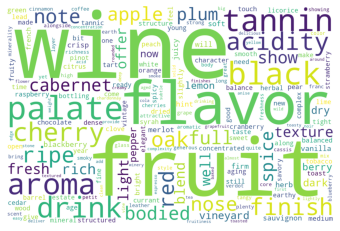

In [16]:
# Initialize wordcloud
wordcloud = WordCloud(
    collocations=False,
    width=1200, height=800,
    background_color='white',
    stopwords=stopwords
)

# Generate wordcloud from our text variable    
wordcloud.generate(reviews)

# Render the wordcloud as an image, turn off the axis, and show
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

1. We can update our set of `stopwords` by calling `.update()`, passing in a list of words that we don't want to appear in the wordcloud.

2. We can update the background color by updating the `background_color` argument.

3. Lastly, we can update the size of the wordcloud by specifying the figure size in `plt.figure()`. Wordcloud is built upon `matplotlib`, so we can adjust figure characteristics by using our `plt` alias for `matplotlib.pyplot`.

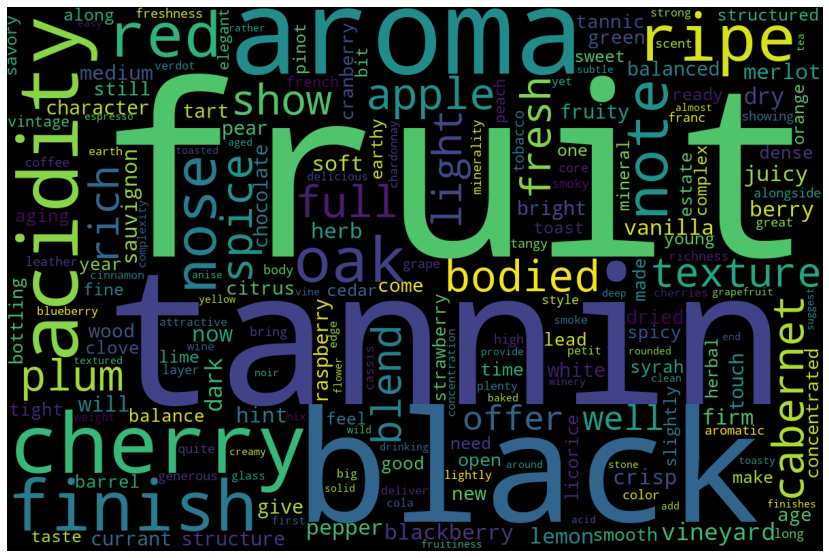

In [17]:
# Less interesting words
wine_words = ['flavor', 'flavors', 'wine', 'drink', 'palate']

# Update our stopwords with words that aren't too interesting to us
stopwords.update(wine_words)

# Generate our wordcloud, but change the background color
wordcloud = WordCloud(
    collocations=False,
    width=1200, height=800,
    background_color='black',
    stopwords=stopwords
)
wordcloud.generate(reviews)

# Display the wordcloud, but with updated size
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## **Simple word count**
While a full runthrough of preprocessing for advanced topics such as natural language processing and machine learning are beyond the scope of this live-training, let's just do a quick preview of how one might get a frequency count of words outside of a wordcloud! To do this we will use:
- `word_tokenize()`: a function we imported earlier from `ntlk.tokenize` that will 'tokenize' or split a string into substrings based on a set of criteria. In this case, we will split based on punctuation, thereby collecting words.
- `Counter()`: a type of dictionary from the `collections` module that stores elements as keys and their counts as values.
- `.most_common()`: a method on a counter object that will return the _n_ most common elements.
- `.isalpha()`: Returns True if all characters are alphabetic.

In [18]:
# Tokenize our existing set of text if the word is alphabetic
tokens = [word for word in word_tokenize(reviews) if word.isalpha()]


# Filter our list for words that aren't in our existing set of stopwords
final_words = [word for word in tokens if word not in stopwords]

# Preview our tokenized list
final_words[:20]

['tremendous',
 'varietal',
 'hails',
 'oakville',
 'aged',
 'three',
 'years',
 'oak',
 'juicy',
 'fruit',
 'compelling',
 'hint',
 'caramel',
 'greet',
 'framed',
 'elegant',
 'fine',
 'tannins',
 'subtle',
 'minty']

In [19]:
# Use counter to create a count of each word in our filtered list final_words
word_count = Counter(final_words)

# Use a loop to print the 10 most common tokens
for word in word_count.most_common(10):
  print(word[0] + ": " + str(word[1]) + " mentions")

fruit: 1535 mentions
black: 1167 mentions
tannins: 1154 mentions
aromas: 1106 mentions
acidity: 1030 mentions
cherry: 984 mentions
finish: 927 mentions
ripe: 808 mentions
oak: 698 mentions
red: 643 mentions


In [20]:
# Check word count for 'tannin' and 'tannins'
print(word_count['tannin'])
print(word_count['tannins'])

118
1154


**Observation:** It looks like our count could be more accurate, as there are nearly identical words included!

## **Stemming and Lemmatization**
### **Stemming**
There are a few ways we can go about fixing this. First, there is stemming, which is an algorithmic way of reducing words to their root form. However, in doing so, it runs the risk of producing non-words as a result. Let's take a look by importing `PorterStemmer()` from `nltk.stem`.
- `PorterStemmer()`: a popular stemmer available in the `nltk.stem` package, based on the Porter stemming algorithm.
- `.stem()`: the method to which we pass the token we want to stem.

In [21]:
# Initialize our stemmer
stemmer = PorterStemmer()

# Generate a list of test words
test_words = ['bike', 'bikes', 'biking']

# View the stemmer in action
print([stemmer.stem(word) for word in test_words ])

['bike', 'bike', 'bike']


In [22]:
# Generate a new list of test words
new_words = ['lease', 'leasing', 'leases']

# View the stemmer in action
print([stemmer.stem(word) for word in new_words ])

['leas', 'leas', 'leas']


**Observation:** It looks like we are already encountering limits of our stemmer! 

### **Lemmatization**
An approach that is slower, but relies upon linguistic rules is the process of _lemmatization_, which attemps to reduce input to its root word, or _lemma_. Unlike the algorithmic approach of stemming, lemmatization uses a corpus to ensure that the root word is an actual word. Let's use `WordNetLemmatizer()` and its corresponding method `.lemmatize()` to try this out!

In [23]:
# Initialize our lemmatizer
lemmatizer = WordNetLemmatizer()

# View the stemmer in action
print([lemmatizer.lemmatize(word) for word in test_words])
print([lemmatizer.lemmatize(word) for word in new_words])

['bike', 'bike', 'biking']
['lease', 'leasing', 'lease']


## **A final pass through our word frequencies**
Okay, now that we have experimented a bit, let's do a final run through our words with a lemmatizer and plot the counts.

In [24]:
# Lemmatize our list with our lemmatizer
lemmatized_words = [lemmatizer.lemmatize(word) for word in final_words]

# Use counter to create a count of each word in our filtered list 
new_word_count = Counter(lemmatized_words)

# Check the success of our lemmatization
print("Old count of tannin: " + str(word_count.get('tannin')))
print("New count of tannin: " + str(new_word_count.get('tannin')))
print("New count of tannins: " + str(new_word_count.get('tannins')))

Old count of tannin: 118
New count of tannin: 1272
New count of tannins: None


In [25]:
# Convert our most common words to a DataFrame for easy plotting
word_freq = pd.DataFrame(new_word_count.most_common(15), index=None, columns=['Word', 'Count'])

# View first five rows
word_freq.head()

,Word,Count
0,fruit,2037
1,tannin,1272
2,black,1167
3,aroma,1155
4,cherry,1112


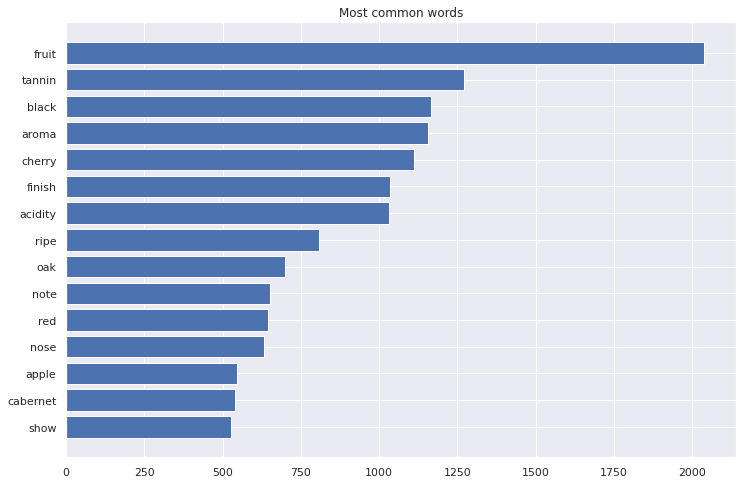

In [26]:
# Set figure size
plt.figure(figsize=(12, 8))

# Create a barplot with our values
plt.barh(y=word_freq.Word, width=word_freq.Count)

# Invert the y axis
plt.gca().invert_yaxis()

# Set the title and show
plt.title('Most common words')
plt.show()

## **Searching for specific strings**
Wordclouds and frequency counts are great starting steps, but to really explore our data we will probably want to be able to search it. Let's do some basic searches for mentions of oak in the `description` column of the DataFrame.
- `str.contains()` will return a Boolean whether a given pattern or string is found in the string of the series. It is based off of `re.search`. 
    - For now, we will use the optional parameters `case` and `regex` to ensure that our search is _not_ case sensitive, and to specify that we are not using a regular expression pattern, and instead simply a string.

In [27]:
# Create our Boolean filter
oak_filter = wine_df['description'].str.contains('oak', case=False, regex=False)

# Filter our DataFrame using our oak_filter and look at the first five rows
wine_df[oak_filter][:5]

,country,description,designation,points,price,province,region,variety,winery,location
0,US,"This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.",Martha's Vineyard,96,235.0,California,Napa Valley,cabernet sauvignon,Heitz,Napa Valley - US
2,US,"This spent 20 months in 30% new French oak, and incorporates fruit from Ponzi's Aurora, Abetina and Madrona vineyards, among others. Aromatic, dense and toasty, it deftly blends aromas and flavors of toast, cigar box, blackberry, black cherry, coffee and graphite. Tannins are polished to a fine sheen, and frame a finish loaded with dark chocolate and espresso. Drink now through 2032.",Reserve,96,65.0,Oregon,Willamette Valley,pinot noir,Ponzi,Willamette Valley - US
9,US,"This blockbuster, powerhouse of a wine suggests blueberry pie and chocolate as it opens in the glass. On the palate, it's smooth and seductively silky, offering complex cedar, peppercorn and peppery oak seasonings amidst its dense richness. It finishes with finesse and spice.",Rainin Vineyard,95,325.0,California,Diamond Mountain District,cabernet sauvignon,Hall,Diamond Mountain District - US
14,US,"Focused and dense, this intense wine captures the essence of ripe raspberries. Aged in 50% new French oak, it's got a strong vein of coffee and mocha. The flavors broaden out and penetrate, finishing with highlights of cedar, cinnamon and dark chocolate. Drink now through the 2020s, but decant if you want the full expression.",Abetina,94,105.0,Oregon,Willamette Valley,pinot noir,Ponzi,Willamette Valley - US
17,US,"Steely and perfumed, this wine sees only 20% new French oak, remaining vibrantly fresh. Baked apple and lemon pith veer into grapefruit on the palate, with spiciness to the finish that's both brash and loud.",Babushka,90,37.0,California,Russian River Valley,chardonnay,Zepaltas,Russian River Valley - US


**Observation:** Take a look at the first result. Although the review does make reference to being aged in `oak`, it also references the wine coming from `Oakville`. Thus, there may be a risk that our query is grabbing descriptions that contain Oakville, and not oak.

**Introduction to Regular Expressions**
---
We could add a space after `'oak'` to ensure that we don't get Oakville, but what about when the word ends a sentence, or `'oakiness'` and `'oaky'`? Enter regular expressions, which allow us to define patterns to find and extract text.

Regular expressions are strings that make use of normal and special characters to help define a pattern which we can then compare to our text of interest. Here, we will make use of a few special characters to write a pattern for `oak` and related adjectives. But first, let's try out some simple examples by using the digit special character.

`\d`: Matches any digit character (i.e. 0-9)

`{}`: Quantifies the number of matches. 
- `{1,5}` will match between 1 and 5.
- `{2,}` will match at least two.

There are many more special characters we can use to write complex regular expression (or regex) patterns, but let's see what we can do with what we have learned so far. We will make use of the `re` package:
- `re.findall()` will return all matches of our patterns in a given string.
- We also prefix our pattern with `r` to denote it as a raw string, so Python interprets our backslashes correctly.

In [28]:
# Create a very contrived test string
test_string = """
This tremendous 100% varietal wine hails from Oakville 
and was aged over three years in oak. Juicy red-cherry fruit 
and a compelling hint of caramel greet the palate, framed by elegant, 
fine tannins and a subtle 20% minty tone in the background. 
Balanced and rewarding from start to finish, 
it has years ahead of it to develop further nuance. There are absolutely no
bad tannins in this wine. But there is a tasty tannin.
Enjoy 2022–2030."""

# Let's find all digits in this review
re.findall(r"\d", test_string)

['1', '0', '0', '2', '0', '2', '0', '2', '2', '2', '0', '3', '0']

In [29]:
# Let's find all years represented in the format XXXX in this review
re.findall(r"\d{4}", test_string)

['2022', '2030']

In [30]:
# Let's find all percentages (with between 1 and 3 digits, followed by a percentage sign)
re.findall(r"\d{1,3}%", test_string)

['100%', '20%']

### **Let's expand a bit on some other special characters before diving back into our dataset!**

`\w`: Matches any alphanumeric character or underscore (i.e. A-Z, a-z, 0-9, \_)

`+`: Matches between 1 or more of the preceding character.

`\s`: Matches any white space character, such as spaces, tabs, and line breaks.

`?`: Matches 0 or more of the preceding character.

In [31]:
# Find all mentions of tannin (or tannins), as well as the word that precedes it for context
re.findall(r"\w+\stannins?", test_string)

['fine tannins', 'bad tannins', 'tasty tannin']

---
## Q&A 2
---

## **Let's learn about oak!**

1. First, we want to ensure that it is the beginning of the string, or preceded by a space, because there may be cases where a word contains the same characters (e.g. `'cloak`'). We do this by using two new techniques: alternation and the carat.
- `^`: matches the position before the first character of a string.
- `|`: acts as an or.
    - Using `()` groups characters together.

```
(\s|^)
```


- `re.search()`: returns a match object if it finds an occurence of the pattern, and `NULL` if it doesn't.

In [32]:
# Test out the pattern
print(re.search(r"(\s|^)oak", "oaky flavors"))
print(re.search(r"(\s|^)oak", "flavored oak"))
print(re.search(r"(\s|^)oak", "cloak"))

<_sre.SRE_Match object; span=(0, 3), match='oak'>
<_sre.SRE_Match object; span=(8, 12), match=' oak'>
None


2. We then want to search for a capitalized or non-capitalized `'o'`. To do this, we can use a character set `[]`, which matches any character in the square brackets. We then add `'a'` and `'k'` as these characters will be in every variant of oak we want to search for.

```
[Oo]ak
```

In [33]:
# Test out character sets
print(re.search(r"[Oo]ak", "Oak"))
print(re.search(r"[Oo]ak", "oak"))

<_sre.SRE_Match object; span=(0, 3), match='Oak'>
<_sre.SRE_Match object; span=(0, 3), match='oak'>


3. Next, we want to allow for variants of oakiness, Here, we use one large capturing group, and then search for any of the inner groups using `|`. 
- We look for `'iness'` **or** s or y (again using square brackets).
    - We make this set optional with `?`.

```
(iness|s|y)?
```


4. Finally, we use a character set that allows for a period, a comma, or white space.
- _Note: we also introduce a `/` before the `.` to 'cancel out' the special character and treat it as a period._

```
[/.,\s]
```

Putting the pieces together, we now have a pattern that will capture all references to oak that we expect to find, while also not matching with words like `'Oakville'`. Let's add these together, and then assign them to the variable `oak_pattern`.

In [34]:
# Search for a white space, 
    # followed by any case 'o', 'ak', 
    # and ending in 'iness', 'y', or a period, comma, or whitespace.
oak_pattern = r"(\s|^)[Oo]ak((iness)|y|s)?[/.,\s]"

### **Testing our pattern**
**Note:** It is always a good idea to test that your regular expression is returning the results that you would expect, especially when you are working with longer and more complex patterns. There are many resources online where you can test patterns, such as www.regexr.com


In [35]:
# Use our pattern to search a string that contains Oakville but not explicitly oak
x = re.search(oak_pattern, "This tremendous 100% varietal wine hails from Oakville.")

# If a match is found, let us know!
if x:
    print("Yes, an oak match!")
else:
    print("No, oak isn't here!")

No, oak isn't here!


In [36]:
# Use our pattern to search a string that contains a reference to something being 'oaky'
x = re.search(oak_pattern, "This tremendous wine is oaky.")

# If a match is found, let us know!
if x:
    print("Yes, an oak match!")
else:
    print("No, oak isn't here!")

Yes, an oak match!


In [37]:
# View the first (and only) match
x[0]

' oaky.'

**Filtering the DataFrame using regex to find interesting patterns**
---
Now that we have a functioning pattern, we can use it to gain insights about the oakiness of wines. First, we use our pattern to filter the DataFrame, again using `str.contains()`, but this time using a regular expression.

We can assign this filtered DataFrame to a new one, titled `oak_wines`, which we can use for further analyses. Let's also call `.head()` to do a sense check on the new DataFrame.

In [38]:
# Filter our DataFrame for descriptions matching our pattern, and assign to `oak_wines`
oak_wines = wine_df[wine_df['description'].str.contains(oak_pattern)]

# View the first five rows of our new DataFrame
oak_wines.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,country,description,designation,points,price,province,region,variety,winery,location
0,US,"This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.",Martha's Vineyard,96,235.0,California,Napa Valley,cabernet sauvignon,Heitz,Napa Valley - US
2,US,"This spent 20 months in 30% new French oak, and incorporates fruit from Ponzi's Aurora, Abetina and Madrona vineyards, among others. Aromatic, dense and toasty, it deftly blends aromas and flavors of toast, cigar box, blackberry, black cherry, coffee and graphite. Tannins are polished to a fine sheen, and frame a finish loaded with dark chocolate and espresso. Drink now through 2032.",Reserve,96,65.0,Oregon,Willamette Valley,pinot noir,Ponzi,Willamette Valley - US
9,US,"This blockbuster, powerhouse of a wine suggests blueberry pie and chocolate as it opens in the glass. On the palate, it's smooth and seductively silky, offering complex cedar, peppercorn and peppery oak seasonings amidst its dense richness. It finishes with finesse and spice.",Rainin Vineyard,95,325.0,California,Diamond Mountain District,cabernet sauvignon,Hall,Diamond Mountain District - US
14,US,"Focused and dense, this intense wine captures the essence of ripe raspberries. Aged in 50% new French oak, it's got a strong vein of coffee and mocha. The flavors broaden out and penetrate, finishing with highlights of cedar, cinnamon and dark chocolate. Drink now through the 2020s, but decant if you want the full expression.",Abetina,94,105.0,Oregon,Willamette Valley,pinot noir,Ponzi,Willamette Valley - US
17,US,"Steely and perfumed, this wine sees only 20% new French oak, remaining vibrantly fresh. Baked apple and lemon pith veer into grapefruit on the palate, with spiciness to the finish that's both brash and loud.",Babushka,90,37.0,California,Russian River Valley,chardonnay,Zepaltas,Russian River Valley - US


### **Performing some comparisons**
Wonderful! Now, let's start to get an idea of the ratios of oakiness between varieties of wines. Let's start by grouping our two DataFrames, `oak_wines` and `wine_df` by the variety and counting the number of references.

To do so, we will use:
- `.groupby()` to group by the `variety`.
- `.count()` to aggregate by the count of different wines.
- `.sort_index()` so that we have an alphabetically sorted index to use for plotting.

In [39]:
# Group our oak DataFrame by variety, count it, and sort the index in descending alphabetical order
oak_grouped = oak_wines.groupby('variety').count()['country'].sort_index(ascending=False)

# Group our original DataFrame by variety, count it, and sort the index in descending alphabetical order
wine_grouped = wine_df.groupby('variety').count()['country'].sort_index(ascending=False)

# Display the two grouped DataFrames
print(oak_grouped)
print(wine_grouped)

variety
syrah                        28
sauvignon blanc              23
riesling                      5
red blend                    97
pinot noir                  172
merlot                       36
chardonnay                  176
cabernet sauvignon          165
bordeaux-style red blend     21
Name: country, dtype: int64
variety
syrah                        237
sauvignon blanc              291
riesling                     202
red blend                    536
pinot noir                  1033
merlot                       149
chardonnay                   696
cabernet sauvignon           527
bordeaux-style red blend     460
Name: country, dtype: int64


### **Plot our ratios**
Let's start by doing a simple plot of the grouped DataFrames. By overlaying the `oak_grouped` data over the `wine_grouped` data, we can get a rough visualization of the ratios of oaky wines. To do this, we will use `matplotlib.pyplot.barh` to make two horizontal barplots.

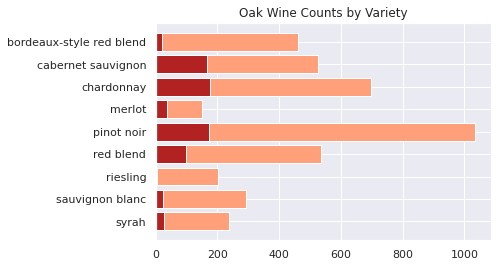

In [40]:
# Plot a horizontal bar chart of the count of varieties in 'lightsalmon'
plt.barh(wine_grouped.index, wine_grouped, color='lightsalmon')

# Plot a horizontal bar chart of the count of oaky varieties in 'firebrick'
plt.barh(oak_grouped.index, oak_grouped, color='firebrick')

# Give the plot a title
plt.title("Oak Wine Counts by Variety")

# Show the plot
plt.show()

### **Calculate ratios**
Clearly there are some varieties that are more likely to be described as oaky than others. Let's create a Boolean (True/False) column called `'oaky'` using our pattern, and then use a `groupby()` to calculate the percentage of each variety that is described as oaky.

**Note:** When calculating the `.mean()` of a Boolean column, `pandas` treats True as 1 and False as 0.

In [41]:
# Generate a new Boolean column based on whether the review contains 'oak'
wine_df['oaky'] = wine_df['description'].str.contains(oak_pattern)

# Group the DataFrame by variety, take the mean, and select the 'oaky' column
oak_freq = wine_df.groupby('variety').mean()['oaky'].sort_values()

# View the resulting percentages
oak_freq

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


variety
riesling                    0.024752
bordeaux-style red blend    0.045652
sauvignon blanc             0.079038
syrah                       0.118143
pinot noir                  0.166505
red blend                   0.180970
merlot                      0.241611
chardonnay                  0.252874
cabernet sauvignon          0.313093
Name: oaky, dtype: float64

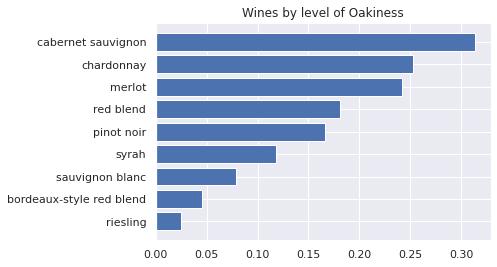

In [42]:
# Create another horizontal bar plot of the frequencies
plt.barh(oak_freq.index, oak_freq)

# Title the plot
plt.title("Wines by level of Oakiness")

# Show the plot
plt.show()

**Finally, let's produce some replicable output!**
---
Let's create some variables from our filtered datasets, and use these to write a replicable expression that adapts based on new data. We can generate some simple summaries using:
- `len()` to find the length of the two DataFrames.
- `.idxmax()` to return the index of the row with the highest value (i.e. the wine with the highest oaky percentage).

In [43]:
# Count the number of rows in the two DataFrames
oak_num = len(oak_wines)
wine_num = len(wine_df)

# Select the wine with the highest percentage of oakiness
oak_wine = oak_freq.idxmax()
print(oak_wine)

cabernet sauvignon


### **Using F strings**
Okay, now let's embed our three variables into an f-string. F-strings allow us to insert our variables into strings using curly brackets `{}`. We simply need to add an `f` as a prefix to our string and call it inside a print function.

We now have a simple and dynamic summary of our data!

In [44]:
# Use an f-string to print a written description of our data
print("There were {:3,} reviews that mention 'oak' from amongst {:3,} reviews. The most oaky wine was {}".format(oak_num, wine_num, oak_wine))

There were 723 reviews that mention 'oak' from amongst 4,131 reviews. The most oaky wine was cabernet sauvignon


In [45]:
# Update our variables and print again
oak_num = 834
wine_num = 4131
oak_wine = 'pinot noir'

print("There were {:3,} reviews that mention 'oak' from amongst {:3,} reviews. The most oaky wine was {}".format(oak_num, wine_num, oak_wine))

There were 834 reviews that mention 'oak' from amongst 4,131 reviews. The most oaky wine was pinot noir


## **What's next?**
Now that you have started your Pythonic-text journey, there are a variety of more advanced topics for you to tackle!

<a href = "https://learn.datacamp.com/courses/regular-expressions-in-python"><img src = "https://assets.datacamp.com/production/course_17118/shields/original/shield_image_course_17118_20200109-1-1b7rdip?1578597449" width=100pt align=left></a><br><br>&nbsp;&nbsp;&nbsp;**Further Experience with Regular Expressions**

<a href = "https://learn.datacamp.com/courses/sentiment-analysis-in-python"><img src = "https://assets.datacamp.com/production/course_16852/shields/original/shield_image_course_16852_20190816-1-1drnml4?1565953559" width=100pt align=left></a><br><br>&nbsp;&nbsp;&nbsp;**Sentiment Analysis**

<a href = "https://learn.datacamp.com/courses/feature-engineering-for-machine-learning-in-python"><img src = "https://assets.datacamp.com/production/course_14336/shields/original/shield_image_course_14336_20190428-1-1s1qt3h?1556485075" width=100pt align=left></a><br><br>&nbsp;&nbsp;&nbsp;**Feature Engineering for Machine Learning**

<a href = "https://learn.datacamp.com/courses/introduction-to-natural-language-processing-in-python"><img src = "https://assets.datacamp.com/production/course_3629/shields/original/shield_image_course_3629_20200424-1-1jg2tak?1587716990" width=100pt align=left></a><br><br>&nbsp;&nbsp;&nbsp;**Natural Language Processing**